In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench import (Model, RealParameter, ScalarOutcome, ema_logging,
                           perform_experiments,TimeSeriesOutcome)
import seaborn as sns

In [2]:
sns.set()
def solar_panels(cost_per_kw_init,capacity,efficiency,hours_sunlight,subsidy,cost_for_municipality,discount_rate_solar):
    emissions_offset = []
    for t in range(0,10):
        cost_per_kw = cost_per_kw_init*(1/(1+discount_rate_solar)**t)
        cost_of_solar_panel = (cost_per_kw*capacity*1000)   
        energy_generated = 365*capacity*efficiency*hours_sunlight
        number_of_households= cost_for_municipality/(subsidy*cost_of_solar_panel)
        net_energy_generated = energy_generated*number_of_households
    
        coal_electricity_lci = 1.00871
        oil_electricity_lci = 0.7695418
        natural_gas_electricity_lci = 0.64291
        coal_production = 17.4  #billion kwh
        oil_production = 3.9 #billion kwh
        natural_gas_production = 71 #billion kwh

        total_fossil = coal_production + natural_gas_production + oil_production
        coal_share = coal_production/total_fossil
        oil_share = oil_production/total_fossil
        naturalgas_share = natural_gas_production/total_fossil

        net_lci_nonrenewable = (coal_share*coal_electricity_lci) + (oil_share*oil_electricity_lci) + (naturalgas_share*natural_gas_electricity_lci)
        solar_lci = 0.050136
        net_emissions_offset = net_energy_generated*(net_lci_nonrenewable-solar_lci)
        number_of_households_hague = 260887
        net_emissions_offset_per_household = net_emissions_offset/number_of_households_hague
        hague_emissions_nonrenewable = 344
        net_emissions_offset_percent = min(100,100*net_emissions_offset_per_household/hague_emissions_nonrenewable)
        emissions_offset.append(net_emissions_offset_percent)
    return {'emissions_offset':emissions_offset}


In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)
model = Model('simpleModel', function=solar_panels)
model.uncertainties = [RealParameter("cost_per_kw_init", 0.5, 2),
                           RealParameter("capacity", 1, 5),
                           RealParameter("efficiency", 0.15, 0.2),
                           RealParameter("hours_sunlight",5,10),
                           RealParameter("discount_rate_solar",0.03,0.07)]
model.levers = [RealParameter("subsidy",0.2,0.6),
               RealParameter("cost_for_municipality",1000000,10000000 )]
    
model.outcomes = [TimeSeriesOutcome('emissions_offset')]

In [5]:
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments,outcomes = evaluator.perform_experiments(scenarios=10000,policies=10)


[MainProcess/INFO] performing 10000 scenarios * 10 policies * 1 model(s) = 100000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] 60000 cases completed
[MainProcess/INFO] 70000 cases completed
[MainProcess/INFO] 80000 cases completed
[MainProcess/INFO] 90000 cases completed
[MainProcess/INFO] 100000 cases completed
[MainProcess/INFO] experiments finished


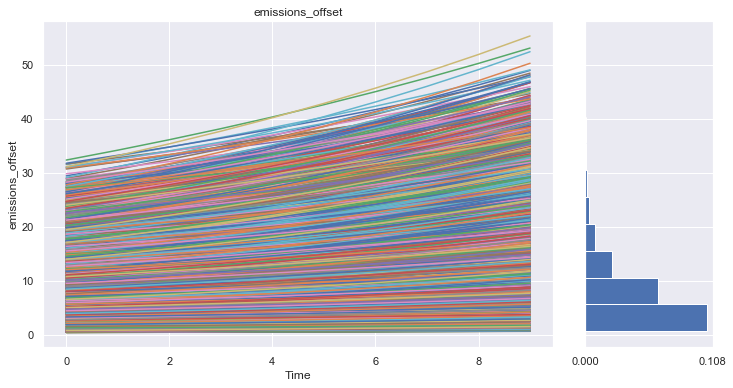

In [14]:
from ema_workbench.analysis import plotting, plotting_util
for outcome in outcomes.keys():
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [8]:
experiments.head()

,capacity,cost_per_kw_init,discount_rate_solar,efficiency,hours_sunlight,cost_for_municipality,subsidy,policy,model
0,1.700644,1.547079,0.052014,0.171560,5.204945,6769153.078,0.551732,0,simpleModel
1,4.082389,0.628241,0.060617,0.165720,9.382246,6769153.078,0.551732,0,simpleModel
2,1.597531,0.778644,0.036351,0.177649,9.743650,6769153.078,0.551732,0,simpleModel
3,4.223532,1.288125,0.067140,0.157772,5.441729,6769153.078,0.551732,0,simpleModel
4,4.997951,1.017317,0.069218,0.168971,8.611892,6769153.078,0.551732,0,simpleModel


[MainProcess/INFO] 100000 points remaining, containing 43575 cases of interest
[MainProcess/INFO] mean: 0.9949188977916749, mass: 0.05117, coverage: 0.11683304647160069, density: 0.9949188977916749 restricted_dimensions: 5


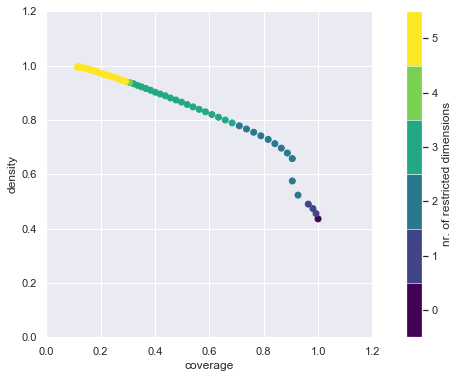

In [10]:
from ema_workbench.analysis import prim
x = experiments[['capacity','cost_per_kw_init','discount_rate_solar','efficiency','hours_sunlight','cost_for_municipality','subsidy']]
y = outcomes['emissions_offset'].flatten()[9::10]
y = y<5
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

[MainProcess/INFO] 100000 points remaining, containing 10000 cases of interest
[MainProcess/INFO] mean: 0.8775199695701787, mass: 0.05258, coverage: 0.4614, density: 0.8775199695701787 restricted_dimensions: 3


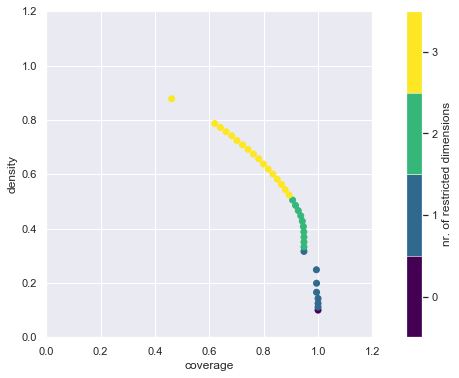

In [15]:
from ema_workbench.analysis import prim
x = experiments[['capacity','cost_per_kw_init','discount_rate_solar','efficiency','hours_sunlight','cost_for_municipality','subsidy']]
y = outcomes['emissions_offset'].flatten()[9::10]
y = y < np.percentile(y, 10)
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

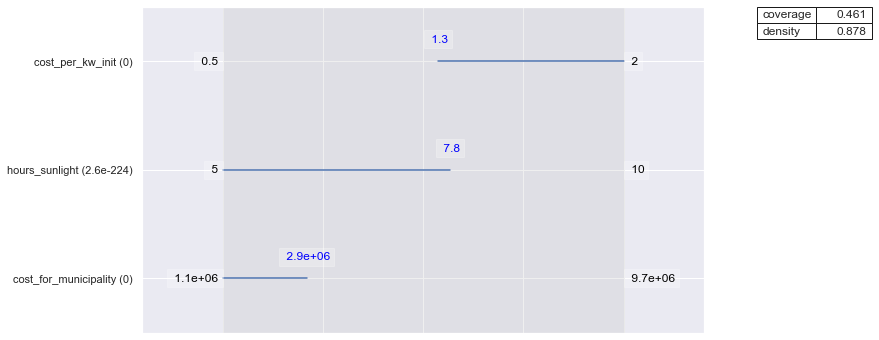

In [16]:
box1.inspect(style='graph')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

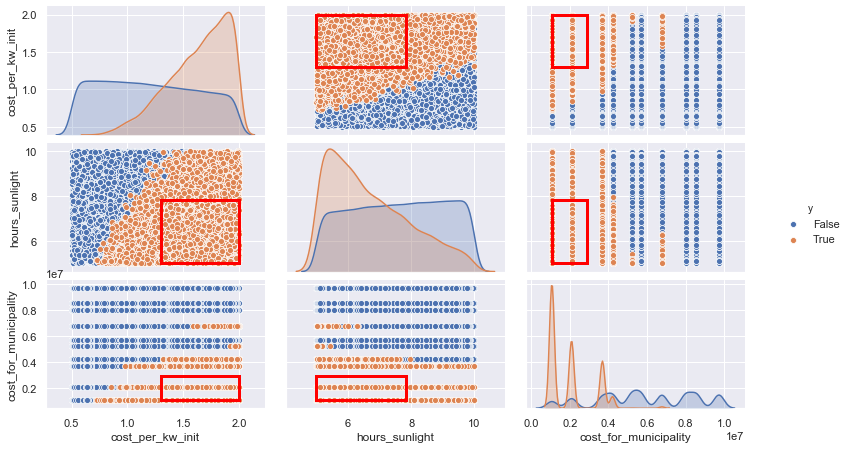

In [17]:
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [27]:
y = outcomes['emissions_offset'].flatten()[9::10]
np.percentile(y,50)

5.613830526741566